```
Large Writer Independent Text Line Recognition Task
This task consists of a total number of 9'862 text lines. It provides one training, one testing, and two validation sets. The text lines of all data sets are mutually exclusive, thus each writer has contributed to one set only.

Set Name	Number of Text Lines	Number of Writers
Train	6'161	283
Validation 1	900	46
Validation 2	940	43
Test	1'861	128
Total	9'862	500
```

In [14]:
import os
import string
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
_DATA_DIRNAME = '../../handwriting_recognition/data/iam'
!ls {_DATA_DIRNAME}

forms  label_by_line_id.json  lines  LWITLR_task  xml


In [3]:
def get_reverse_dict(input_dict):
    return {v: k for k, v in input_dict.items()}

def read_image(image_uri, grayscale=True):
    """
    Read image_uri.
    """
    def read_image_from_filename(image_filename, grayscale):
        imread_flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
        return cv2.imread(image_filename, imread_flag)

    def read_image_from_url(image_url, grayscale):
        url_response = urlopen(image_url)
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        imread_flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
        return cv2.imdecode(img_array, imread_flag)

    local_file = os.path.exists(image_uri)
    try:
        img = None
        if local_file:
            img = read_image_from_filename(image_uri, grayscale)
        else:
            img = read_image_from_url(image_uri, grayscale)
    except Exception as e:
        raise ValueError("Could not load image at {}: {}".format(image_uri, e))
    return img

def resize(image, scale_factor):
    """
    Resize image.
    OpenCV does not resize in place, hence need to copy and return in case
    scale_factor is 1 to maintain consistency in behaviour
    """
    if scale_factor == 1:
        return image.copy()
    return cv2.resize(
        image,
        dsize=None,
        fx=scale_factor,
        fy=scale_factor,
        interpolation=cv2.INTER_AREA
    )

In [4]:
def char_to_int_mapping():
    """
    Creates and returns a hash table mapping the characters to integer class indexes.
    The characters are an extension of IAM graphemes.
        00 -- 09: Digits
        10 -- 35: Capital Letters
        36 -- 61: Lower Letters
        62 -- 76: - , ; : ! ? / . ' " ( ) * & +
        77: # (garbage symbol)
        78: word separator (space in ground truth)
        79 -- 92: = _ [ ] { } ^ $ > < % | @ ~
        93: <ctc blank label> - not a part of the dict
    """
    return {
        char: ind for ind, char
        in enumerate(
            string.digits +
            string.ascii_uppercase +
            string.ascii_lowercase +
            '-,;:!?/.\'"()*&+# =_[]{}^$><%|@~'
        )
    }

char_to_int_dict = char_to_int_mapping()

In [9]:
def get_iam_labels(label_file):
    with open(label_file, 'r') as f:
        labels_dict = json.load(f)
    return labels_dict


def get_line_id_from_filename(filename):
    """
    Input example: '../data/iam/words_5/g06-031e-02-00.png' or '../data/iam/words_5/g06-031e-02.png'
    Output example: 'g06-031e-02'  (line_id)
    """
    return '-'.join(os.path.splitext(os.path.basename(filename))[0].split('-')[:3])


def iam_helper(image_directory, label_dict, label_to_int_mapping, image_height):
    """Create an IAM dataset object from IAM-DB images
    Args:
        buckets: a sorted list of integers describing image widths of all buckets
        label_dict: a dictionary with key being image id and value being its label
    """
    dirname = os.path.join(_DATA_DIRNAME, 'LWITLR_task')
    train_index_path = os.path.join(dirname, 'trainset.txt')
    val_index_path = os.path.join(dirname, 'validationset2.txt')
    test_index_path = os.path.join(dirname, 'testset.txt')

    assert os.path.exists(train_index_path) and os.path.exists(val_index_path) and os.path.exists(test_index_path)

    int_to_label_mapping = get_reverse_dict(label_to_int_mapping)

    def load_iam_lines(index_path):
        with open(index_path, 'r') as f:
            image_filenames = f.read().splitlines()
        image_filenames = [os.path.join(image_directory, '{}.png'.format(fname)) for fname in image_filenames]
        return load(image_filenames, get_line_id_from_filename)

    def load_image(image_filename):
        image = read_image(image_filename, grayscale=True)
        image = 255. - image
        image = resize(image, (image_height / image.shape[0]))
        return image / 255.
        
    def load(image_filenames, get_label_key_func):
        images = [load_image(fname) for fname in image_filenames]
        labels = [label_dict[get_label_key_func(filename)] for filename in image_filenames]
        int_labels = [[label_to_int_mapping[c] for c in label] for label in labels]
        return images, labels  #int_labels

    x_train, y_train = load_iam_lines(train_index_path)
    x_val, y_val = load_iam_lines(val_index_path)
    x_test, y_test = load_iam_lines(test_index_path)

    print(f'Number of images in train: {len(x_train)}')
    print(f'Number of images in val: {len(x_val)}')
    print(f'Number of images in test: {len(x_test)}')

    return x_train, y_train, x_val, y_val, x_test, y_test

In [10]:
image_height = 28
image_directory = os.path.join(_DATA_DIRNAME, 'lines')
label_by_line_id = get_iam_labels(os.path.join(_DATA_DIRNAME, 'label_by_line_id.json'))

assert os.path.exists(image_directory)

x_train, y_train, x_val, y_val, x_test, y_test = iam_helper(
    image_directory=image_directory,
    label_dict=label_by_line_id,
    label_to_int_mapping=char_to_int_dict,
    image_height=image_height
)

Number of images in train: 6161
Number of images in val: 940
Number of images in test: 1861


In [ ]:
### check if images and labels match

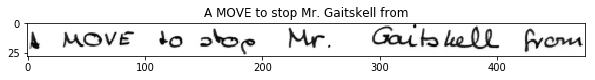

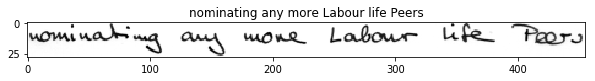

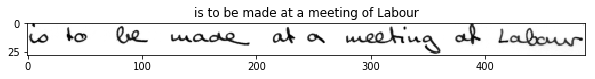

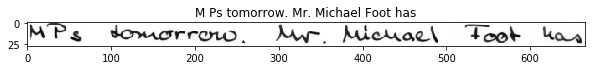

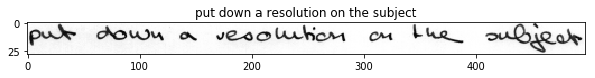

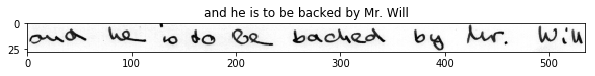

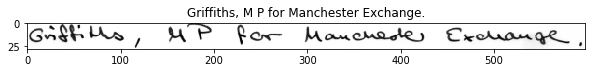

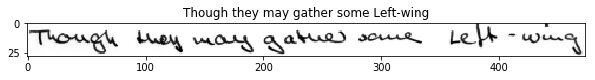

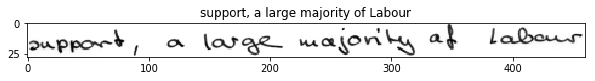

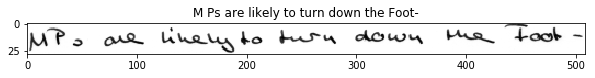

In [18]:
for i in range(10):
    plt.figure(figsize=(10, 10))
    plt.title(y_train[i])
    plt.imshow(x_train[i], cmap='gray')

In [23]:
import h5py
## np.uint8
processed_iam_filename = 'datasets/processd_iam.h5'

## not working because images have different lengths
with h5py.File(processed_iam_filename, 'w') as f:
    f.create_dataset('x_train', data=x_train, dtype='u1', compression='lzf')
    f.create_dataset('y_train', data=y_train, dtype='u1', compression='lzf')
    f.create_dataset('x_val', data=x_val, dtype='u1', compression='lzf')
    f.create_dataset('y_val', data=y_val, dtype='u1', compression='lzf')
    f.create_dataset('x_test', data=x_test, dtype='u1', compression='lzf')
    f.create_dataset('y_test', data=y_test, dtype='u1', compression='lzf')

ValueError: could not broadcast input array from shape (28,475) into shape (28)

In [29]:
iam_vocabulary = set(' '.join(y_train + y_val + y_test))
iam_vocabulary

{' ',
 '!',
 '"',
 '#',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [ ]:
[' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', ]